In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import gpboost as gpb

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=6, edgeitems = 7)
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', None)

Notebook objective: Test GPBoost model with a random effect intercept for an arbitrary grouping variable, and with store_id as a target encoded fixed predictor. Goal is to understand why the GPBoost booster doesn't seem to learn properly.

# Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./InputData/full_data.csv")

In [5]:
# Reindex data from 0:N
df = df.reset_index(drop = True)

In [6]:
# Drop rows with too high duration
high_end = 10800 # 3 hours
df = df[df["duration"] <= high_end]

In [7]:
# Split features & target, drop non-feature columns
X = df.drop(["created_at", "actual_delivery_time", "duration"], axis = 1)
y = df.duration

In [8]:
# Create random group variable
rng = np.random.default_rng(random_state)
G = rng.choice(100, size = y.shape)

In [9]:
np.unique(G, return_counts = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       dtype=int64),
 array([1101, 1090, 1111, 1084, 1099, 1106, 1123, 1104, 1085, 1042, 1121,
        1137, 1096, 1043, 1154, 1099, 1087, 1144, 1097, 1110, 1061, 1096,
        1074, 1052, 1180, 1071, 1115, 1116, 1103, 1100, 1113, 1119, 1085,
        1095, 1090, 1141, 1119, 1058, 1031, 1139, 1153, 1129, 1121, 1126,
        1127, 1132, 1070, 1144, 1132, 1092, 1104, 1149, 1149, 1179, 1079,
        1106, 1123, 1127, 1130, 1108, 1048, 1139, 1097, 1063, 1132, 1130,
        1106, 1115, 1054, 1044, 1118, 1119, 1091, 1053, 1104, 1108, 1065,
        1060

In [10]:
# Enforce dtype of group variable
G = G.astype("str") 

In [11]:
train_end = int(len(df) * 0.6)

In [12]:
val_end = train_end + int(len(df) * 0.2)

In [13]:
# Train - val - test split, 60 - 20 - 20
X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
G_train, G_val, G_test = G[:train_end], G[train_end:val_end], G[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

In [14]:
# Create target encoders

# store_id encoder with hierarchy, top level market_id
hierarchy = pd.DataFrame(X["market_id"]).rename({"market_id": "HIER_store_id_1"}, axis = 1)
encoder_storeid = TargetEncoder(cols = ["store_id"], hierarchy = hierarchy)

# Encoder for remaining categoricals, without hierarchy
encoder = TargetEncoder(cols = ["market_id", "store_primary_category", "order_protocol"])

pipeline = Pipeline([
    ("encoder_storeid", encoder_storeid),
    ("encoder", encoder)
])

In [15]:
# Preprocess data
X_train = pipeline .fit_transform(X_train, y_train)
X_val = pipeline .transform(X_val)
X_test = pipeline .transform(X_test)

# Hyperparameter tuning

In [26]:
# Objective function
def objective_gpb(trial):

    # Define hyperparameter space
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.5)
    num_leaves = trial.suggest_int("num_leaves", 2**2, 2**10)
    #max_depth = trial.suggest_int("max_depth", 2, 20) # Max depth of 20 is too restrictive for LightGBM
    min_child_samples = trial.suggest_int("min_child_samples", 10, 1000, log = True)
    min_child_weight = trial.suggest_float("min_child_weight", 0.001, 20, log = True)
    reg_alpha = trial.suggest_float("l1_reg", 0, 1)
    reg_lambda = trial.suggest_float("l2_reg", 0, 2)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.25, 1)

    # Create model
    #callbacks = [gpb.early_stopping(50)]
    
    model = gpb.GPBoostRegressor(
        n_jobs = 10,
        #device_type = "gpu",
        n_estimators = 5000,
        num_leaves = num_leaves,
        random_state = random_state,
        #max_depth = max_depth,
        max_depth = -1,
        min_child_samples = min_child_samples,
        learning_rate = learning_rate,
        min_child_weight = min_child_weight,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        colsample_bytree = colsample_bytree
    )

    # Create random effects model
    gp_model = gpb.GPModel(
        group_data = G_train, # Random intercepts for each group
        likelihood = "gaussian",
        seed = random_state
    )
    gp_model.set_prediction_data(group_data_pred = G_val)

    # Train model with early stopping
    model.fit(
        X_train, 
        y_train,
        gp_model = gp_model, 
        eval_set = [(X_val, y_val)],
        early_stopping_rounds = 50,
        #callbacks = callbacks,
        verbose = False)

    # Report best number of rounds
    trial.set_user_attr("n_rounds", (model.best_iteration_ + 1))
    
    return model.best_score_['valid_0']['l2']


In [27]:
# Create study
study_gpb = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_state),
  study_name = "tune_gpb",
  direction = "minimize"
)

[I 2023-11-29 18:47:48,453] A new study created in memory with name: tune_gpb


In [ ]:
# Perform study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_gpb.optimize(
  objective_gpb, 
  n_trials = 100,
  show_progress_bar = True)

In [30]:
# Save tuning log
trials_gpb = study_gpb.trials_dataframe().sort_values("value", ascending = True)
trials_gpb.to_csv("./ModifiedData/trials_gpb_random.csv", index = False)

# Testing & diagnostics

In [16]:
# Load best tune
best_tune = pd.read_csv("./ModifiedData/trials_gpb_random.csv").iloc[0]

In [17]:
best_tune

number                                              27
value                                    997921.078500
datetime_start              2023-11-29 18:58:40.712618
datetime_complete           2023-11-29 18:59:17.288824
duration                        0 days 00:00:36.576206
params_colsample_bytree                       0.629845
params_l1_reg                                 0.002815
params_l2_reg                                 0.257295
params_learning_rate                          0.459331
params_min_child_samples                           353
params_min_child_weight                       0.063274
params_num_leaves                                  305
user_attrs_n_rounds                        5001.000000
state                                         COMPLETE
Name: 0, dtype: object

In [18]:
# Combine train & validation data
X_train, X_test = X[:val_end], X[val_end:]
G_train, G_test = G[:val_end], G[val_end:]
y_train, y_test = y[:val_end], y[val_end:]

In [19]:
# Preprocess data
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

In [20]:
# Create gpb data
train = gpb.Dataset(X_train, y_train)
test = gpb.Dataset(X_test, y_test)

In [21]:
# Create random effects model
gp_model = gpb.GPModel(
        group_data = G_train,
        likelihood = "gaussian",
        seed = random_state
    )

In [22]:
# Create params dict
params = {
    "random_state": random_state,
    "n_estimators": int(best_tune["user_attrs_n_rounds"]),
    "num_leaves": best_tune["params_num_leaves"],
    "min_child_samples": best_tune["params_min_child_samples"],
    "learning_rate": best_tune["params_learning_rate"],
    "min_child_weight": best_tune["params_min_child_weight"],
    "reg_alpha": best_tune["params_l1_reg"],
    "reg_lambda": best_tune["params_l2_reg"],
    "colsample_bytree": best_tune["params_colsample_bytree"]
}

In [23]:
# Train booster
model = gpb.train(
    params = params,
    train_set = train,
    gp_model = gp_model
)

Found `n_estimators` in params. Will use it instead of argument


[GPBoost] [Info] Total Bins 3127
[GPBoost] [Info] Number of data points in the train set: 88345, number of used features: 29
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=2816.359805
[GPBoost] [Info] Start training from score 2816.359805


In [24]:
# Make predictions on test data
preds = model.predict(X_test, group_data_pred = G_test, predict_var = True, pred_latent = True)

In [25]:
preds

{'fixed_effect': array([2818.117402, 2817.648017, 2817.889473, 2817.443853, 2818.441093,
        2817.262527, 2816.273586, ..., 2814.908918, 2815.176515,
        2814.513033, 2814.899992, 2816.299467, 2815.995963, 2815.700643]),
 'random_effect_mean': array([-0.302843, -0.853709,  1.772847, -1.235796,  0.30289 ,  0.406613,
        -0.782142, ..., -0.75435 , -0.537814, -2.090851,  0.159226,
         0.072792, -1.916346, -1.508099]),
 'random_effect_cov': array([41.506851, 41.560728, 41.5116  , 41.552796, 41.521099, 41.473644,
        41.557555, ..., 41.519516, 41.522683, 41.476804, 41.451536,
        41.423145, 41.510017, 41.484707]),
 'response_mean': None,
 'response_var': None}

In [26]:
# Combine back with test data
df_pred = X_test.copy()
df_pred["fixed"] = preds['fixed_effect']
df_pred["random"] = preds["random_effect_mean"]
df_pred["random_sd"] = np.sqrt(preds["random_effect_cov"])
df_pred["preds"] = df_pred["fixed"] + df_pred["random"]
df_pred["actual"] = y_test
df_pred["residual"] = y_test - df_pred["preds"]

In [27]:
# Calculate RMSE, MAPE
print("RMSE:")
print(mean_squared_error(df_pred["actual"], df_pred["preds"], squared = False))

print("MAPE:")
print(mean_absolute_percentage_error(df_pred["actual"], df_pred["preds"]))

RMSE:
1129.8846664522835
MAPE:
0.3001082256187391


In [28]:
# Predict with random effect only for comparison
re_model = gpb.GPModel(
        group_data = G_train,
        likelihood = "gaussian",
        seed = random_state
    )
re_model.fit(y = y_train, X = np.ones(y_train.shape)) # Fixed intercept + group RE
preds_re = re_model.predict(X_pred = np.ones(y_test.shape), group_data_pred = G_test, predict_var = True)
print("RMSE:")
print(mean_squared_error(y_test, preds_re["mu"], squared = False))

print("MAPE:")
print(mean_absolute_percentage_error(y_test, preds_re["mu"]))

RMSE:
1130.317534064648
MAPE:
0.30025661759554034


In [29]:
# Range (lack thereof) of fixed effect predictions
df_pred["fixed"].describe()

count   22087.000000
mean     2816.406560
std         0.897922
min      2814.340145
25%      2815.739694
50%      2816.311531
75%      2817.015261
max      2819.337500
Name: fixed, dtype: float64

In [30]:
# Range of random effect predictions
df_pred["random"].describe()

count   22087.000000
mean        0.014970
std         1.200202
min        -3.005353
25%        -0.835640
50%        -0.017573
75%         0.822253
max         3.172273
Name: random, dtype: float64

In [36]:
# Target mean in training data
y_train.mean()

2816.359805308733

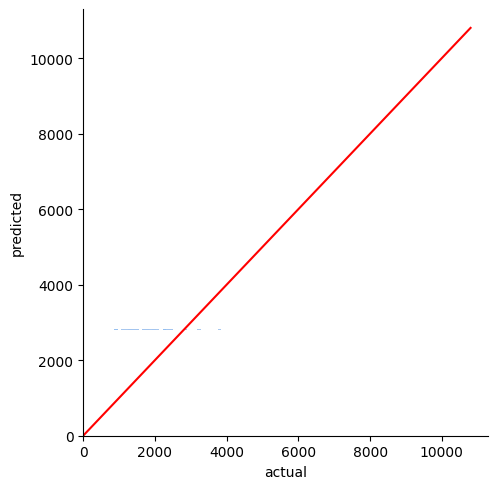

In [31]:
# Plot predicted vs. actual
_ = sns.displot(x = df_pred["actual"],  y = df_pred["preds"])
_ = plt.plot([0, high_end], [0, high_end], c = "red")
_ = plt.xlim(0, high_end + 500)
_ = plt.ylim(0, high_end + 500)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

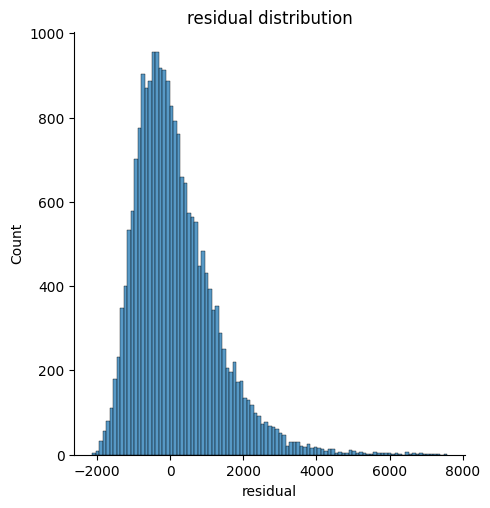

In [32]:
# Residual distribution
_ = sns.displot(df_pred["residual"])
_ = plt.title("residual distribution")

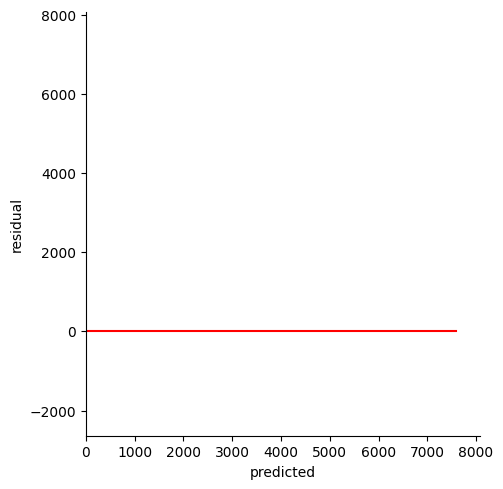

In [33]:
# Predicted vs residual
low_end = min(df_pred.residual)
max_resids = max(df_pred.residual)
_ = sns.displot(data = df_pred, x = "preds", y= "residual")
_ = plt.plot([0, max_resids], [0, 0], c = "red")
_ = plt.xlim(0, max_resids + 500)
_ = plt.ylim(low_end - 500, max_resids + 500)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

In [34]:
# Random effects model summary for GPBoost
gp_model.summary()

Covariance parameters (random effects):
                   Param.
Error_term 1088628.546400
Group_1         42.980100


In [35]:
# RE only model summary
re_model.summary()

Model summary:
       Log-lik            AIC            BIC
-739418.100000 1478842.200000 1478870.370000
Nb. observations: 88345
Nb. groups: 100 (Group_1)
-----------------------------------------------------
Covariance parameters (random effects):
                   Param.
Error_term 1089507.218100
Group_1        223.068800
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                 Param.
Covariate_1 2816.360300


# Findings
- The fixed effects model predicts the target mean, and random effects predictions are close to zero. Which means the latter is working properly, but not the former.
- The tuning rounds each trained for the maximum of 5000 rounds, though their scores are practically the same. This means there was a minimal improvement in every single round.